In [ ]:
# New to Jupyter notebook? Check out the Jupyter notebook 
# documentation (https://jupyter-notebook.readthedocs.io/en/stable/ui_components.html), 
# and try the User interface tour in the Help menu above.

# BlockSci Setup

In [1]:
import blocksci
import matplotlib.pyplot as plt
import matplotlib.ticker
import collections
import pandas as pd
import numpy as np
%matplotlib notebook

In [2]:
# parser_data_directory should be set to the data-directory which the blocksci_parser output
chain = blocksci.Blockchain("/home/ubuntu/bitcoin")

# Measuring different types of address use

In [3]:
%time net_coins_per_block = chain.map_blocks(lambda block: block.net_address_type_value())

CPU times: user 6.5 s, sys: 1.44 s, total: 7.94 s
Wall time: 2min 8s


(0, 13313558.289755534)

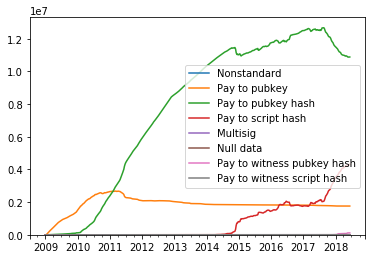

In [4]:
df = pd.DataFrame(net_coins_per_block).fillna(0).cumsum()/1e8
df = chain.heights_to_dates(df)
df = df.rename(columns={t:str(t) for t in df.columns})
ax = df.resample("W").mean().plot()
ax.set_ylim(ymin=0)

# Visualizing Transaction Fees for an individual block

In [ ]:
example_block_height = 465100
df = pd.DataFrame(chain[example_block_height].txes.fee_per_byte(), columns=["Satoshis per byte"])
ax = df.reset_index().plot.scatter(x="index", y="Satoshis per byte")
ax.set_ylim(0)
ax.set_xlim(0)
plt.show()

# Identifying Overlay Applications

In [ ]:
%time txes = chain.blocks.txes.including_output_of_type(blocksci.address_type.nulldata).all

In [ ]:
%time labels = [(tx.block.time, blocksci.label_application(tx)) for tx in txes]

In [ ]:
df = pd.DataFrame(labels, columns=["date", "label"])
df = df.reset_index().groupby(["date", "label"]).count().unstack(level=-1).fillna(0)
df.columns = df.columns.droplevel()
important_columns = list(df[df.index > pd.to_datetime("1-1-2016")].sum().sort_values()[-10:].index)
important_columns = [x for x in important_columns if "Address" not in x]
ax = df[df.index > pd.to_datetime("1-1-2016")].cumsum().resample("w").mean()[important_columns].plot()
ax.set_ylim(0)
plt.tight_layout()

# Average Fee per Transaction in 2017 in USD

In [ ]:
converter = blocksci.CurrencyConverter()

In [ ]:
# BlockSci vectorized interface
blocks = chain.range('2017')
%time fees = blocks.fee / blocks.tx_count
times = blocks.time

In [ ]:
df = pd.DataFrame({"Fee":fees}, index=times)
df = converter.satoshi_to_currency_df(df, chain)
ax = df.resample("d").mean().plot(legend=False)
ax.set_ylim(ymin=0)
plt.tight_layout()

# Transactions Paying over 1000 dollars in fees

In [ ]:
%time high_fee_txes = chain.cpp.filter_tx("fee(tx) > 10000000", 0, len(chain))

In [ ]:
converter = blocksci.CurrencyConverter()

In [ ]:
df = pd.DataFrame([(tx.block.height, tx.fee) for tx in high_fee_txes], columns=["height", "fee"])
df.index = df["height"]
df["fee"] = df.apply(lambda x: converter.satoshi_to_currency(x["fee"], chain[x["height"]].time), axis=1)
df = df[df["fee"] > 1000]
df = chain.heights_to_dates(df)
fig, ax = plt.subplots()
ax.plot_date(df.index, df["fee"], fmt="x")
ax.set_yscale("log")
formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)
plt.tight_layout()

# Balance held by cluster

In [ ]:
# cluster_data_directory should be set to the directory containing the
# output of the `clusterer` program
cm = blocksci.cluster.ClusterManager("/home/ubuntu/bitcoin/clusters", chain)

In [ ]:
# Find the balance held by the cluster containing the given address at block height 494653 
address = chain.address_from_string("3EhLZarJUNSfV6TWMZY1Nh5mi3FMsdHa5U")
cluster = cm.cluster_with_address(address)
sum(address.balance(494653) for address in cluster.addresses) / 1e8